久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第5章 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using DataFrames
using GLM
using Plots
using Distributions

## 5.2 尤度比検定の例題：逸脱度の差を調べる

In [2]:
d = CSV.read("data3a.csv");
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink());
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink());

**尤度比**（_likelihood ratio_）を対数化して-2をかけたものが逸脱度の差$\Delta D$になる。
$$ \frac{L_1^\ast}{L_2^\ast} $$
$$ \Delta D_{1,2} = -2\times\left(\log L_1^\ast - \log L_2^\ast\right) $$

In [3]:
D1 = -2 * loglikelihood(fit1)
D2 = -2 * loglikelihood(fit2)
deltaD = D1 - D2   # deviance(fit1) - deviance(fit2) でも同じ

4.5139410788519285

この4.5という値の大きさが十分なのかどうかをどうやって確認するの？というのが、この後の中心的な話題。

## 5.4 帰無仮説を棄却するための有意水準

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法（p.102）



In [4]:
deviance(fit1) - deviance(fit2)

4.513941078851829

In [5]:
d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)

100-element Array{Int64,1}:
  8
  8
  7
 17
 14
 13
 14
  4
  9
  3
  6
 10
  5
 11
 12
 11
  7
 11
  8
 11
  7
  6
  6
  2
 12
  7
  8
 12
  6
  ⋮
  8
  6
 10
  4
  7
  8
  8
 13
  8
  6
  5
  9
  5
  7
  9
  8
  8
 11
 10
  7
  2
  9
  8
  7
  5
 11
  8
  5

In [6]:
d

,y,x,f,y_rnd
,Int64⍰,Float64⍰,String⍰,Int64
1,6,8.31,C,8
2,6,9.44,C,8
3,6,9.5,C,7
4,12,9.07,C,17
5,10,10.16,C,14
6,4,8.32,C,13
7,9,10.61,C,14
8,9,10.06,C,4
9,9,9.93,C,9


In [7]:
fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
deviance(fit1) - deviance(fit2)

1.320229432785382

これを1000回くらい繰り返して、ランダム生成したデータの逸脱度の差の平均や標準偏差をみる。単純な方法は以下の`for`を使うやり方。

In [8]:
N = 1000
dd12 = zeros(N)
for n=1:N
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    dd12[n] = deviance(fit1) - deviance(fit2)
end

p.104のコードをJuliaで書くと以下のようになるだろうか。`replicate()`の代わりにarray comprehensionを使った。

In [9]:
function get_dd(d)
    n_sample = nrow(d)
    y_mean = mean(d[:y])
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    return(deviance(fit1) - deviance(fit2))
end

function pb(d, n_bootstrap)
    [get_dd(d) for n=1:n_bootstrap]
end

N = 1000
dd12 = pb(d, N)

1000-element Array{Float64,1}:
 0.082205904559288    
 0.0016955521742545443
 3.166936245982086    
 1.473831637672916    
 3.3847722685358264   
 0.812246959596763    
 0.21055748075244196  
 6.210571084810383    
 0.17367905966689534  
 0.3840151562789629   
 0.25622842177172345  
 0.04989011179662839  
 2.318192992960846    
 0.8923167056227754   
 1.5038920422770872   
 2.8343064613891187   
 0.03644788115700237  
 0.0009376267368850222
 0.0063996544026707625
 0.22622826100683824  
 1.1871672930161736   
 0.5776491654488325   
 0.0270973845086786   
 0.3812194554841426   
 2.345271383319414e-5 
 2.4866099514199362   
 0.3898116696714311   
 2.014203442544428    
 0.11213331616855271  
 ⋮                    
 0.04483820073390632  
 0.6458038700100275   
 1.9100160752311126   
 0.2457052638956725   
 0.11807462278896708  
 0.19804186269442425  
 0.1386651131672494   
 1.1943155131202587   
 1.1761659734979304   
 0.03610146011691029  
 0.4999089979350657   
 1.5347275151673898   
 3.

In [10]:
describe(dd12)

Summary Stats:
Mean:           1.026362
Minimum:        0.000006
1st Quartile:   0.094908
Median:         0.455339
3rd Quartile:   1.327883
Maximum:        14.256941
Length:         1000
Type:           Float64


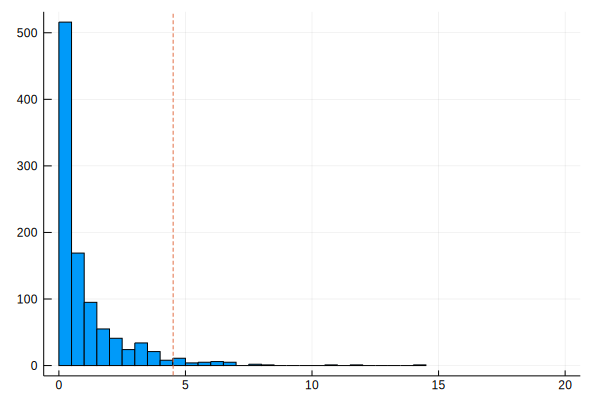

In [11]:
histogram(dd12, xlim=[0, 20], legend=false)
vline!([deltaD], linestyle=:dash)

In [12]:
sum(dd12 .>= deltaD)

37

In [13]:
p_value = sum(dd12 .>= deltaD) / length(dd12)

0.037

In [14]:
α = 0.05
quantile(dd12, 1-α)

3.758685959957325

有意水準5%では上記の数値くらいまでの逸脱度の差は「よくある差」だと判断できる。

### 3.4.2 方法(2) カイ二乗分布を使った近似計算法

JuliaにRのようなANOVAは無さそうなので、コード例をそのままJuliaに移植することはできない。でもカイ二乗分布の累積分布関数を使ってp値を求めることはできる。

In [15]:
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink())
dd12 = deviance(fit1) - deviance(fit2)
1 - cdf(Chisq(1), dd12)

0.03361969100898521